In [160]:
from data import load_data
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
from scipy import optimize

In [3]:
x_train, y_train, x_test, y_test = load_data(test_size = 0.15)

== Loading data ==


In [4]:
x_train.shape

(4250, 3072)

(array([  59.,  384., 1003., 1277.,  915.,  426.,  143.,   29.,   11.,
           3.]),
 array([ 0.89428604,  1.80681564,  2.71934524,  3.63187484,  4.54440444,
         5.45693404,  6.36946364,  7.28199324,  8.19452284,  9.10705244,
        10.01958204]),
 <BarContainer object of 10 artists>)

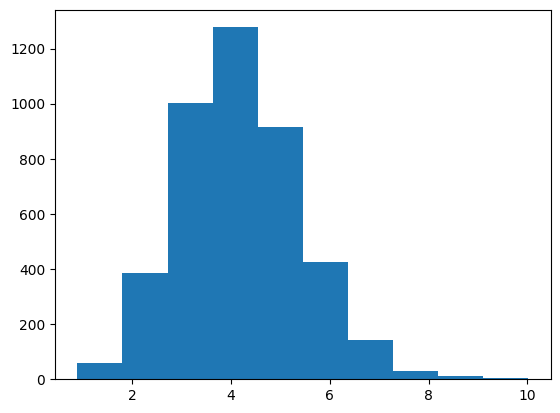

In [5]:
plt.hist(np.linalg.norm(x_train, axis=1)**2)

In [6]:
x_train.var()*3072

4.185638314946319

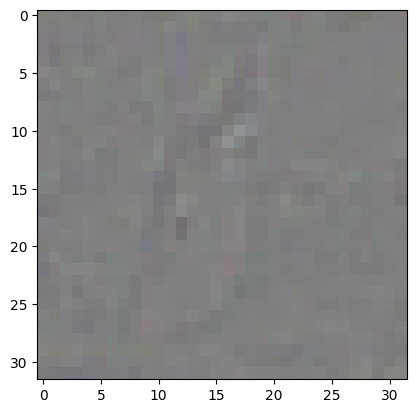

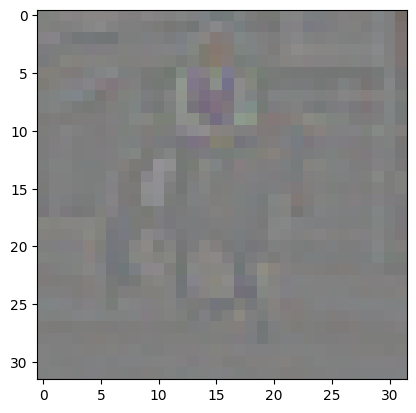

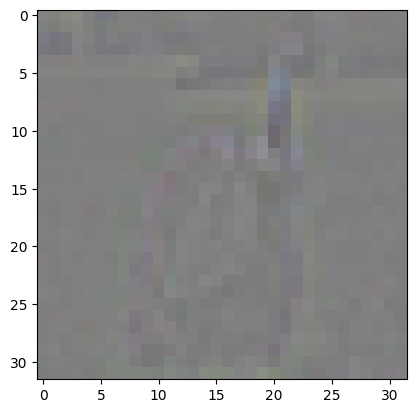

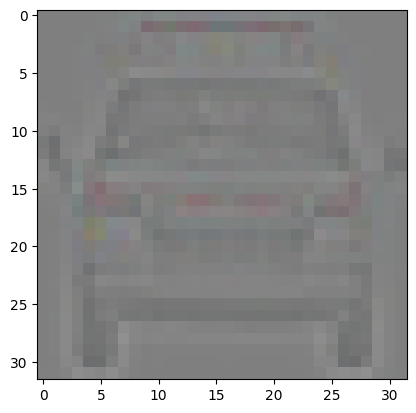

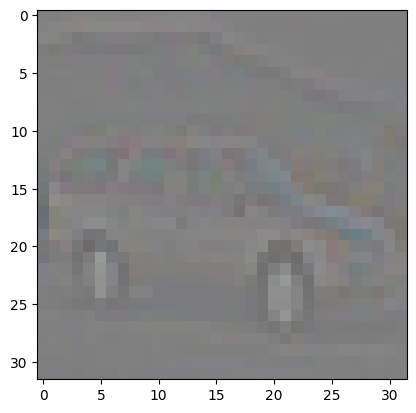

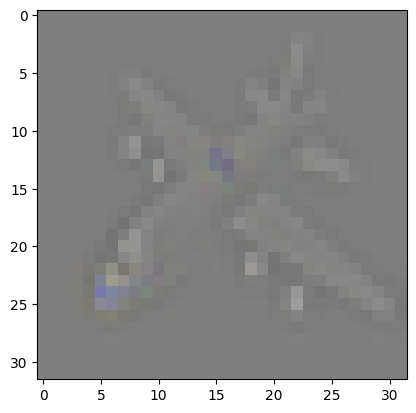

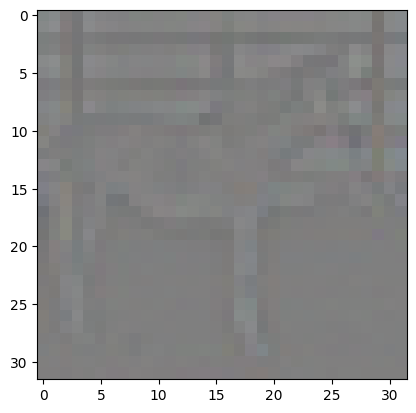

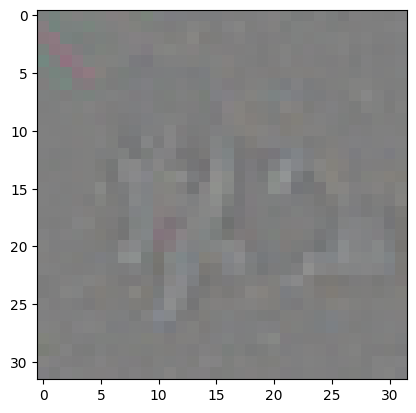

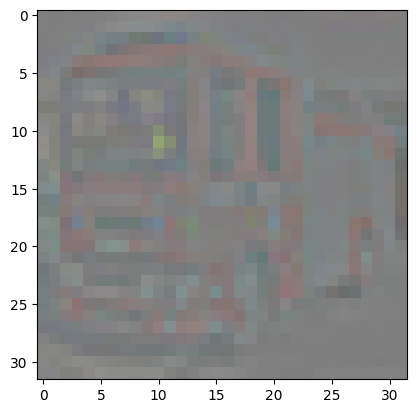

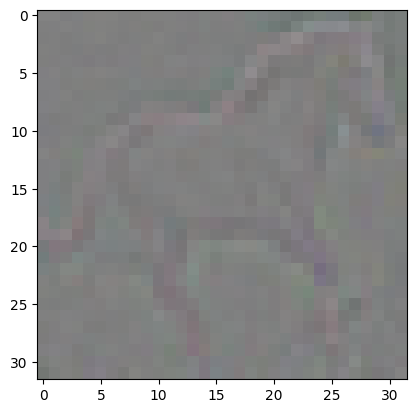

In [7]:
index = 8
for index in range(10):
    plt.figure()
    img = 0.5*(x_train[index]+1)
    h, w = 32, 32
    img = np.reshape(img, (3, h, w))
    img = np.moveaxis(img, 0, 2) # N x h x w x 3
    plt.imshow(img)

In [8]:
index = 11
def get_image(index):
    img = x_train[index, :].reshape(3, 32, 32)
    img = np.uint8(0.5*(img+1)*255)
    img = np.moveaxis(img, 0, 2) # N x h x w x 3
    return img

In [9]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [10]:
img = get_image(index)
img2 = get_image(13)

# Grandient computation

In [172]:
from skimage import filters
from skimage.color import rgb2lab, lab2rgb

In [173]:
img_lab = rgb2lab(img)
img_lab = img_lab[:, :, 0]

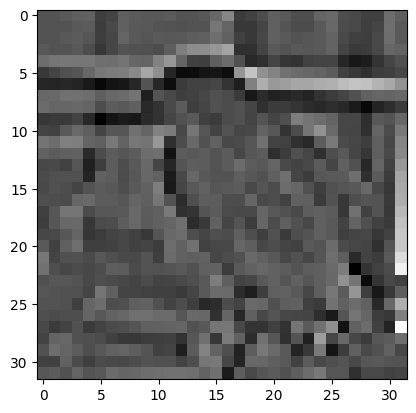

In [174]:
# plt.imshow(lab2rgb(img_lab))
plt.imshow(img_lab, cmap="grey")

In [179]:
edge_roberts = filters.roberts(img_lab)
edge_sobel = filters.sobel(img_lab)
# q = np.quantile(edge_roberts, 0.3)
# edge_roberts[edge_roberts < q] = 0

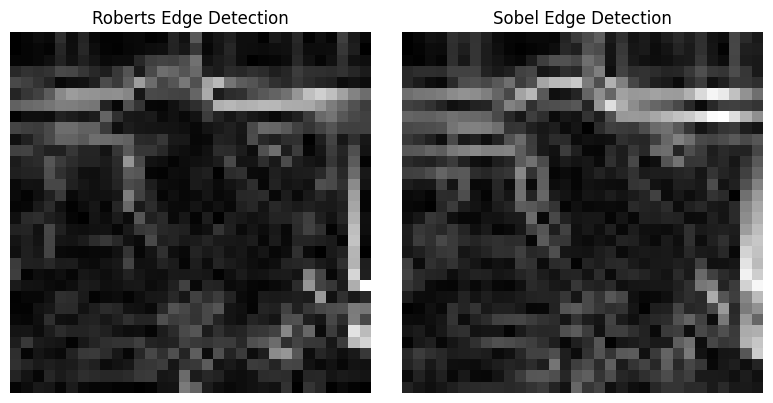

In [180]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(8, 4))

axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [181]:
edge_roberts = np.uint8(edge_roberts/np.max(edge_roberts)*255)

# Watershed transform

Text(0.5, 1.0, 'Separated objects')

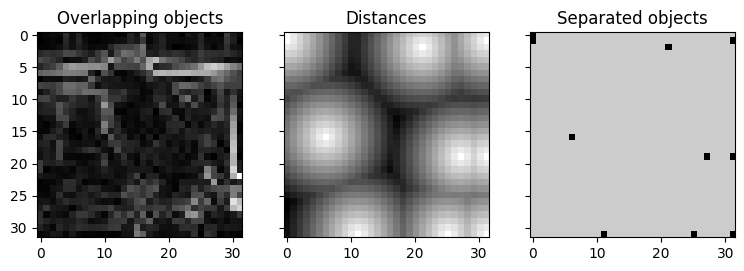

In [182]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(edge_roberts)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=edge_roberts)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=edge_roberts)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

# Histogram Kernel

(32, 32, 3)

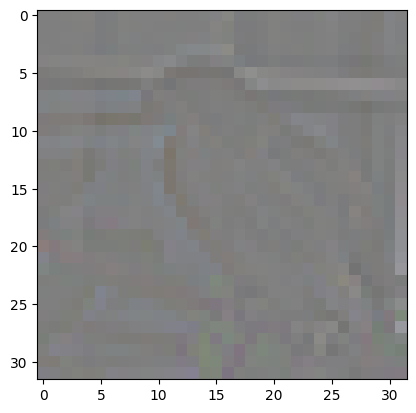

In [186]:
plt.imshow(img)
img.shape

In [194]:
hist, D = np.histogramdd(img.reshape(-1, 3), bins = 16, range = [[0, 255], [0, 255], [0, 255]])

In [199]:
hist = hist.flatten()

In [196]:
D

[array([  0.    ,  15.9375,  31.875 ,  47.8125,  63.75  ,  79.6875,
         95.625 , 111.5625, 127.5   , 143.4375, 159.375 , 175.3125,
        191.25  , 207.1875, 223.125 , 239.0625, 255.    ]),
 array([  0.    ,  15.9375,  31.875 ,  47.8125,  63.75  ,  79.6875,
         95.625 , 111.5625, 127.5   , 143.4375, 159.375 , 175.3125,
        191.25  , 207.1875, 223.125 , 239.0625, 255.    ]),
 array([  0.    ,  15.9375,  31.875 ,  47.8125,  63.75  ,  79.6875,
         95.625 , 111.5625, 127.5   , 143.4375, 159.375 , 175.3125,
        191.25  , 207.1875, 223.125 , 239.0625, 255.    ])]

In [223]:
def hist_kernel(img1, img2, mu, lambd):
    p, _ = np.histogramdd(img1.reshape(-1, 3), bins = 16, range = [[0, 255], [0, 255], [0, 255]])
    q, _ = np.histogramdd(img2.reshape(-1, 3), bins = 16, range = [[0, 255], [0, 255], [0, 255]])
    p = p.flatten()
    p = p/len(p)
    q = q.flatten()
    q = q/len(q)
    eps = 1e-5
    d_ki2 = np.sum((p - q)**2/((p+q)+eps))
    return lambd*np.exp(-mu*d_ki2)

In [14]:
img.shape

(32, 32, 3)

In [230]:
hist_kernel(img, img2, 50, 1)

0.35840097962431594

In [15]:
p, _ = np.histogramdd(img.reshape(-1, 3))

In [92]:
from kernels import HistogramKernel, RBF

In [45]:
ker = HistogramKernel("", mu=50, lambd=10)

In [47]:
img1 = np.random.randn(200, 32, 32, 3)
img2 = np.random.randn(200, 32, 32, 3)

In [49]:
ker(img1, img2, use_cache=False)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.90it/s]


array([[ 9.9032282 ,  9.98849234,  9.73125513, ...,  9.95129885,
         9.9981368 ,  9.97762609],
       [ 9.99172891,  9.892886  ,  9.90954742, ..., 10.        ,
         9.93049951,  9.8636897 ],
       [ 9.87480306,  9.99588675,  9.68587279, ...,  9.93049951,
        10.        ,  9.98866333],
       ...,
       [ 9.56382393,  9.93786909,  9.25998849, ...,  9.67224937,
         9.90205348,  9.95711591],
       [ 9.8259931 , 10.        ,  9.61231453, ...,  9.892886  ,
         9.99588675,  9.99820528],
       [ 9.9750086 ,  9.93211005,  9.86507316, ...,  9.99548066,
         9.96130601,  9.90841424]])

In [63]:
import fast_histogram
import tqdm

In [64]:
fast_histogram.histogramdd(img1[0].reshape(-1, 3), range=[[0, 255], [0, 255], [0, 255]], bins=[16, 16, 16]).shape

(16, 16, 16)

In [74]:
class FastHistogramKernel():
    def __init__(self, cache_file, mu, lambd, bins = 16):
        # super().__init__(cache_file)
        self.mu = mu
        self.lambd = lambd
        self.bins = bins

    def __call__(self, X, Y):
        # K = super().__call__(use_cache)
        # if K is not None:
        #     return K
        # X: N x h x w x 3
        # Y: M x h x w x 3
        N, M = (X.shape[0], Y.shape[0])
        X = X.reshape(N, -1, 3)
        Y = Y.reshape(M, -1, 3)
        K = np.zeros((N, M))
        for i in tqdm.tqdm(range(N)):
            for j in range(M):   
                p = fast_histogram.histogramdd(X[i], range=[[0, 255], [0, 255], [0, 255]], bins=[16, 16, 16])
                q = fast_histogram.histogramdd(Y[j], range=[[0, 255], [0, 255], [0, 255]], bins=[16, 16, 16])
                # p, _ = np.histogramdd(X[i], bins = self.bins, range = [[0, 255], [0, 255], [0, 255]])
                # q, _ = np.histogramdd(Y[j], bins = self.bins, range = [[0, 255], [0, 255], [0, 255]])
                p = p.flatten()
                p = p/len(p)
                q = q.flatten()
                q = q/len(q)
                eps = 1e-5
                d_ki2 = np.sum((p - q)**2/((p+q)+eps))
                K[i, j] = self.lambd*np.exp(-self.mu*d_ki2)
        return K

In [75]:
ker2 = FastHistogramKernel("", mu=50, lambd=10)

In [76]:
ker2(img1, img2)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.95it/s]


array([[ 9.9032282 ,  9.98849234,  9.73125513, ...,  9.95129885,
         9.9981368 ,  9.97762609],
       [ 9.99172891,  9.892886  ,  9.90954742, ..., 10.        ,
         9.93049951,  9.8636897 ],
       [ 9.87480306,  9.99588675,  9.68587279, ...,  9.93049951,
        10.        ,  9.98866333],
       ...,
       [ 9.56382393,  9.93786909,  9.25998849, ...,  9.67224937,
         9.90205348,  9.95711591],
       [ 9.8259931 , 10.        ,  9.61231453, ...,  9.892886  ,
         9.99588675,  9.99820528],
       [ 9.9750086 ,  9.93211005,  9.86507316, ...,  9.99548066,
         9.96130601,  9.90841424]])

In [134]:
del KernelSVC
from svc import KernelSVC
from multiclass_svc import MultiClassSVC
from utils import solve_cvxopt
from cvxopt import matrix, solvers

In [118]:
x_train, y_train, x_test, y_test = load_data(test_size = 0.15)

== Loading data ==


In [119]:
x_new, y_new = MultiClassSVC.split_ovo(x_train, y_train, 5, 2)
print(x_new.shape, y_new.shape)

(835, 3072) (835,)


In [120]:
C = 10
epsilon = 1e-10

In [126]:
kernel = RBF(sigma = 4,cache_file = "")
dy = np.diag(y_new)
K = kernel(x_new, x_new, use_cache=True)

In [127]:
K.shape

(835, 835)

In [153]:
def solve_cvxopt(K, dy, C, y):
    N = K.shape[0]
    Q = matrix(dy @ K @ dy)
    p = matrix(-np.ones(N))
    G = matrix(np.concatenate((-1*np.identity(N), np.identity(N))))
    h = matrix(np.concatenate((np.zeros(N), np.ones(N)*C)))
    A = matrix(y.astype('float'), (1, N))
    b = matrix(0., (1, 1))
    print(np.array(Q).shape, np.array(p).shape, np.array(G).shape, np.array(h).shape, np.array(A).shape, b)
    
    sol = solvers.qp(Q, p, G, h, A, b)
    return np.array(sol['x'])[:, 0]

In [155]:
def solve_scipy(K, dy, C, y):
    N = K.shape[0]
    # Lagrange dual problem
    def loss(alpha):
        l = -np.sum(alpha)+ 1/2 * alpha.T @ dy @ K @ dy @ alpha
        return l #'''--------------dual loss ------------------ '''

    # Partial derivate of Ld on alpha
    def grad_loss(alpha):
        g = -np.ones(N)+ dy @ K @ dy @ alpha
        return g# '''----------------partial derivative of the dual loss wrt alpha -----------------'''
        
    # Constraints on alpha of the shape :
    # -  d - C*alpha  = 0
    # -  b - A*alpha >= 0
    
    fun_eq = lambda alpha: np.dot(y, alpha) # '''----------------function defining the equality constraint------------------'''        
    jac_eq = lambda alpha: y #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
    fun_ineq = lambda alpha: np.concatenate((np.ones(N)*C - alpha, alpha))#  2N'''---------------function defining the inequality constraint-------------------'''  
    jac_ineq = lambda alpha:np.concatenate((-1*np.identity(N), np.identity(N)))  # 2N x N# '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''

    
    constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                    {'type': 'ineq','fun': fun_ineq, 'jac': jac_ineq})
    optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                x0=np.ones(N), 
                                method='SLSQP', 
                                jac=lambda alpha: grad_loss(alpha), 
                                constraints=constraints)
    return optRes.x

In [162]:
t = time.time()
alpha_cvxopt = solve_cvxopt(K, dy, C, y_new)
print("time taken: ", time.time() - t)

(835, 835) (835, 1) (1670, 835) (1670, 1) (1, 835) [ 0.00e+00]

time taken:  0.3125605583190918


In [164]:
t = time.time()
alpha_scipy = solve_scipy(K, dy, C, y_new)
print("time taken: ", time.time() - t)

time taken:  60.98155474662781


In [163]:
alpha_cvxopt

array([9.99999901e+00, 9.99999967e+00, 7.00923448e+00, 9.99999964e+00,
       5.66314676e+00, 9.59897929e+00, 9.92854641e+00, 9.99999906e+00,
       9.99995338e+00, 9.99999974e+00, 6.38318568e+00, 3.60503781e+00,
       9.59128981e+00, 1.22755103e-04, 8.27204920e+00, 7.59096899e+00,
       7.07312407e+00, 9.99999990e+00, 9.57389376e+00, 2.58823975e-07,
       2.10990492e+00, 8.23392889e+00, 6.57355781e+00, 4.91839182e+00,
       7.32718158e+00, 1.17082318e-07, 2.89779471e+00, 2.46759048e+00,
       3.08726609e+00, 9.99999975e+00, 9.99999987e+00, 2.71332499e+00,
       4.94950513e-07, 9.99999979e+00, 9.91059316e+00, 1.95446480e-07,
       6.92364464e+00, 1.71733247e-03, 4.31298292e+00, 9.99999788e+00,
       5.43760185e+00, 2.70922172e-01, 9.99999986e+00, 9.99998249e+00,
       9.99999910e+00, 3.58677398e+00, 7.75867256e+00, 3.76868873e+00,
       6.29160000e+00, 8.59373576e+00, 7.76389047e-01, 1.70676696e+00,
       4.24530534e+00, 7.66071950e+00, 9.99999959e+00, 3.76186862e+00,
      

In [165]:
alpha_scipy

array([ 1.00000000e+01,  1.00000000e+01,  7.00907845e+00,  1.00000000e+01,
        5.66296387e+00,  9.59882919e+00,  9.93600028e+00,  1.00000000e+01,
        1.00000000e+01,  1.00000000e+01,  6.38289506e+00,  3.60540975e+00,
        9.59242273e+00,  9.55800900e-13,  8.27176700e+00,  7.58986649e+00,
        7.07228136e+00,  1.00000000e+01,  9.57410178e+00,  1.44855711e-12,
        2.11005908e+00,  8.23464640e+00,  6.57373116e+00,  4.91798546e+00,
        7.32813632e+00,  1.36792422e-12,  2.89644588e+00,  2.46729189e+00,
        3.08817733e+00,  1.00000000e+01,  1.00000000e+01,  2.71489789e+00,
        1.72341810e-12,  1.00000000e+01,  9.91551922e+00,  1.04419313e-12,
        6.92309038e+00, -8.96426300e-14,  4.31209260e+00,  1.00000000e+01,
        5.44065906e+00,  2.72483050e-01,  1.00000000e+01,  1.00000000e+01,
        1.00000000e+01,  3.58810951e+00,  7.75929770e+00,  3.76885035e+00,
        6.29278874e+00,  8.59404506e+00,  7.77007457e-01,  1.70620239e+00,
        4.24560896e+00,  

(array([64., 69., 84., 60., 88., 81., 94., 74., 57., 79.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

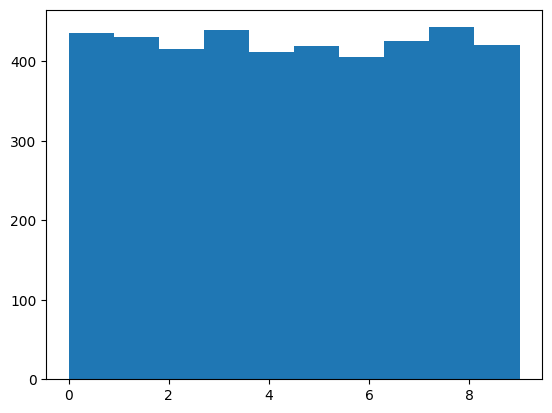

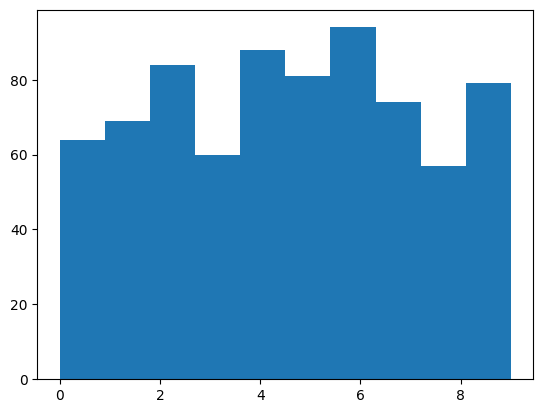

In [168]:
plt.hist(y_train)
plt.figure()
plt.hist(y_test)